# XGBoost Notebook

In this notebook I will train an XGBoost model end to end.

### Description

This is the April 2025 podcast listening time podcast prediction competition.

The goal is to analyze and predict the average listening duration of podcast episodes based on various features.

### Files
1. train.csv
2. test.csv
3. sample_submission.csv

### Evaluation

The evaluation metric is the RMSE.

Submission File
For each id in the test set, you must predict the number of minutes listened. The file should contain a header and have the following format:

- id,Listening_Time_minutes
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

## Package Importing

In [3]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import ydata_profiling
import seaborn as sns

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import xgboost as xgb

/Users/cbutler/repos/personal_repos/Kaggle_S5E4/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cbutler/repos/personal_repos/Kaggle_S5E4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Importing

In [21]:
folder_path = '../data/raw'
df_train = pd.read_csv(f'{folder_path}/train.csv')
df_test = pd.read_csv(f'{folder_path}/test.csv')
sample = pd.read_csv(f'{folder_path}/sample_submission.csv')

In [22]:
TARGET_COLUMN = 'Listening_Time_minutes'

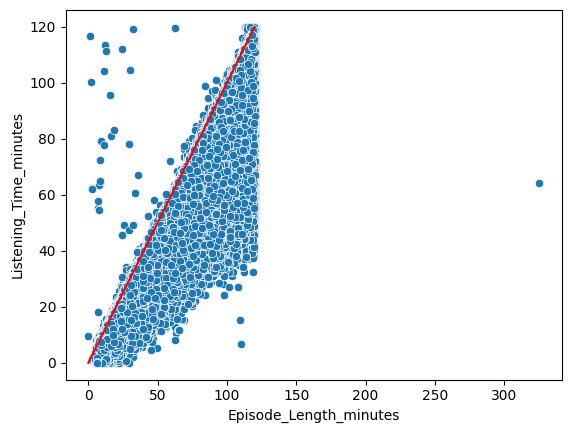

In [23]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=df_train.Episode_Length_minutes,
    y=df_train[TARGET_COLUMN],
    ax=ax
)



line = np.linspace(start=0,stop=df_train.Listening_Time_minutes.max(),num=5)
plt.plot(
    line,
    line,
    color='red'
)

# This appears to be an issue, the average 
# listening time should not be greater than the actual size of the listening time

{'whiskers': [<matplotlib.lines.Line2D at 0x1736358b0>,
 'caps': [<matplotlib.lines.Line2D at 0x173635df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3417a1b50>,
 'medians': [<matplotlib.lines.Line2D at 0x3316fb370>,
 'fliers': [<matplotlib.lines.Line2D at 0x3316fb610>,
 'means': []}

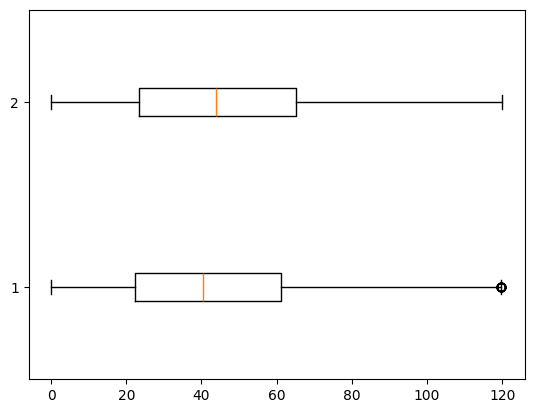

In [24]:
fig,ax = plt.subplots()

a = [
    df_train.loc[df_train.Episode_Length_minutes.isna(),TARGET_COLUMN],
    df_train.loc[~df_train.Episode_Length_minutes.isna(),TARGET_COLUMN],
]


ax.boxplot(
    a,
    vert=False,
)


## Data Cleaning

### Plan for data cleaning for first model
0.  id
    - drop
1.  Podcast_Name - drop
    - drop
2.  Episode_Title - parse out episode number
    - parse out episode number
3.  Episode_Length_minutes
    - impute with mean
4.  Genre
    - drop
5.  Host_Popularity_percentage
    - impute with mean
6.  Publication_Day
    - drop
7.  Publication_Time
    - drop
8.  Guest_Popularity_percentage
    - impute with mean
9.  Number_of_Ads
    - impute one missing value with mean
10.  Episode_Sentiment
    - drop
11.  Listening_Time_minutes - target

In [25]:
def feature_engineering(df):
    
    # Parse episode number
    df['Episode_Number'] = (
        df
            ['Episode_Title']
            .str.split(' ') # split based on space so that each element is a list ['Episode','12']
            .apply(lambda lst: lst[1])
            .astype('float64')
    )
    
    df = df.drop(columns='Episode_Title')

    return df

In [26]:
def preprocessing(df):
    
    # Drop non-important columns
    columns_to_drop = ['Podcast_Name', 'Genre','Publication_Time','Episode_Sentiment','id', 'Publication_Day']
    
    df = df.drop(columns=columns_to_drop)

    df = feature_engineering(df)

    # Pre-processing of training data in kfold
    X = df.loc[:,df.columns != TARGET_COLUMN].to_numpy()
    
    y = df.loc[:,TARGET_COLUMN].to_numpy()

    return X, y # Enabled this to stop warnings



## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [ ]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import root_mean_squared_error

NUMBER_OF_SPLITS = 5
    
kfold_splits = KFold(n_splits=NUMBER_OF_SPLITS)

X_train, y_train = preprocessing(df_train)

hyperparameters = {
    "learning_rate": 0.015,
    "max_depth": 6,
    "n_estimators": 700,
    "random_state": 42,
    "objective": 'reg:squarederror'
}

# Defining XGBoost Parameters
xgboost_model=xgb.XGBRegressor(
    **hyperparameters
)

cv = cross_val_score(
    estimator=xgboost_model,
    X=X_train,
    y=y_train,
    cv=kfold_splits,
    scoring='neg_root_mean_squared_error',
    verbose=10,
)

In [32]:
xgboost_model = xgb.XGBRegressor(
    **hyperparameters
)

xgboost_model.fit(X_train,y_train)

2025/04/21 22:56:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f5483cf0b48495babc12062fa59d0e0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


🏃 View run clumsy-pug-271 at: http://localhost:5000/#/experiments/1/runs/4f5483cf0b48495babc12062fa59d0e0
🧪 View experiment at: http://localhost:5000/#/experiments/1


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri("http://localhost:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(hyperparameters)

    # Log the loss metric
    mlflow.log_metric("neg_root_mean_squared_error", sum(cv)/len(cv))

    # Infer the model signature
    signature = infer_signature(
        model_input=X_train,
        model_output=y_train,
    )

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=xgboost_model,
        artifact_path="xgboost_model",
        signature=signature,
        input_example=X_train,
    )


🏃 View run big-koi-765 at: http://localhost:5000/#/experiments/2/runs/b0b7c65c4aa84fa1a9cd4f4bf5ebea85
🧪 View experiment at: http://localhost:5000/#/experiments/2


# Test Set Validation

In [ ]:
# Defining XGBoost Parameters
xgboost_model=xgb.XGBRegressor(
    **hyperparameters
)

In [9]:
# Training on entire dataset
X_train = df_train.loc[:,df_train.columns != TARGET_COLUMN]
X_train = preprocessing(X_train)

y_train = df_train.loc[:,TARGET_COLUMN].to_numpy()

In [ ]:
xgboost_model.fit(X_train,y_train)

2025/04/21 20:22:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '622b234e0e014a61a9c9797fe45d1297', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


🏃 View run redolent-cub-387 at: http://localhost:5000/#/experiments/1/runs/622b234e0e014a61a9c9797fe45d1297
🧪 View experiment at: http://localhost:5000/#/experiments/1


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
X_test = preprocessing(df_test)

In [12]:
y_preds = xgboost_model.predict(X_test)

In [13]:
df_submission = pd.DataFrame(
    y_preds,
    columns=['Listening_Time_minutes'],
    index=df_test.id
)

In [16]:
# write the csv to the submissions folder
df_submission.to_csv('../submissions/xgboost_impute_with_median_for_guest_popularity.csv')

In [15]:
df_submission

,Listening_Time_minutes
id,
750000,56.517708
750001,18.227524
750002,49.621071
750003,77.622375
750004,49.313473
...,...
999995,12.012521
999996,58.677685
999997,6.646736
